In [45]:
import os
import glob

from ase import io
import numpy as np
import matplotlib.pyplot as plt


In [46]:
fnames = glob.glob("configs/coord.*.xyz")
fnames.sort()
n_atoms = []
for fname in fnames:
    atoms = io.read(fname)
    n_atoms.append(len(atoms))
n_atoms = np.array(n_atoms)

# DW model (python)


In [47]:
fnames = glob.glob("py_dw/dw.*.out")
fnames.sort()
fnames_compressed = glob.glob("py_dw/dw-compressed.*.out")
fnames_compressed.sort()

data_ave = []
data_std = []
data_compressed_ave = []
data_compressed_std = []
ratio = []
ratio_std = []
for fname, fname_compressed in zip(fnames, fnames_compressed):
    data = np.loadtxt(fname)[1:]
    data_compressed = np.loadtxt(fname_compressed)[1:]

    data_ave.append(np.mean(data))
    data_std.append(np.std(data))
    data_compressed_ave.append(np.mean(data_compressed))
    data_compressed_std.append(np.std(data_compressed))
    ratio.append(np.mean(data) / np.mean(data_compressed))
    ratio_std.append(
        ratio[-1]
        * np.sqrt(
            (np.std(data) / np.mean(data)) ** 2
            + (np.std(data_compressed) / np.mean(data_compressed)) ** 2
        )
    )
data_ave = np.array(data_ave)
data_std = np.array(data_std)
data_compressed_ave = np.array(data_compressed_ave)
data_compressed_std = np.array(data_compressed_std)
ratio = np.array(ratio)
ratio_std = np.array(ratio_std)

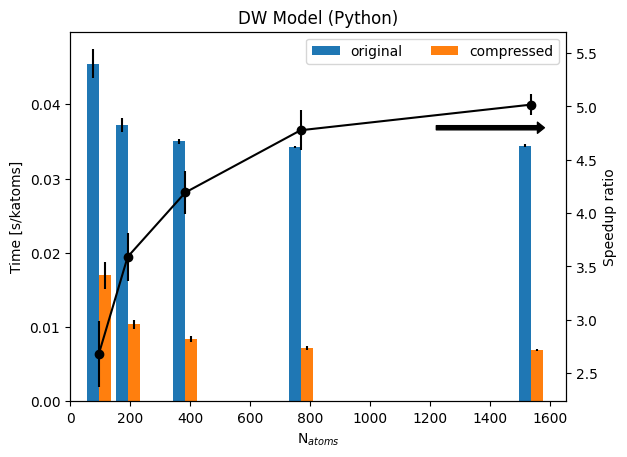

In [48]:
fig, ax = plt.subplots()

x = n_atoms
width = 40
multiplier = 0

ax.bar(
    x - width / 2,
    data_ave / n_atoms * 1e3,
    width,
    yerr=data_std / n_atoms * 1e3,
    label="original",
)
ax.bar(
    x + width / 2,
    data_compressed_ave / n_atoms * 1e3,
    width,
    yerr=data_compressed_std / n_atoms * 1e3,
    label="compressed",
)

ax.set_xlabel(r"N$_{atoms}$")
ax.set_ylabel(r"Time [s/katoms]")
ax.set_xlim(left=0)
ax.legend(ncols=2)

ax_r = ax.twinx()

ax_r.errorbar(n_atoms, ratio, yerr=ratio_std, color="k", fmt="-o")
ax_r.set_ylim(top=5.7)
ax_r.annotate(
    "",
    xy=(1600, 4.8),
    xytext=(1200, 4.8),
    arrowprops=dict(facecolor="black", shrink=0.05, width=3, headwidth=8, headlength=5),
)
ax_r.set_ylabel("Speedup ratio")

fig.savefig("plot/py_dw.png")
plt.title('DW Model (Python)')
plt.show()

# DW model (LAMMPS)


In [49]:
def grep_modify(fname: str):
    with open(fname, "r") as f:
        lines = f.readlines()
        for line in lines:
            if "Modify  |" in line:
                break
    return (
        float(line.split("|")[1]),
        float(line.split("|")[2]),
        float(line.split("|")[3]),
    )

In [50]:
ts_min = []
ts_ave = []
ts_max = []
fnames = glob.glob("./lmp_dw/original.*/log.lammps")
fnames.sort()
for fname in fnames:
    out = grep_modify(fname)
    ts_min.append(out[0])
    ts_ave.append(out[1])
    ts_max.append(out[2])

ts_min_compressed = []
ts_ave_compressed = []
ts_max_compressed = []
fnames = glob.glob("./lmp_dw/compressed.*/log.lammps")
fnames.sort()
for fname in fnames:
    out = grep_modify(fname)
    ts_min_compressed.append(out[0])
    ts_ave_compressed.append(out[1])
    ts_max_compressed.append(out[2])

In [51]:
np.array(ts_ave) / n_atoms * 1e3  # second/(katoms*step)

array([0.00236271, 0.00172245, 0.00088799, 0.00052013, 0.00026458])

In [52]:
np.array(ts_ave_compressed) / n_atoms * 1e3

array([0.00245854, 0.00165271, 0.00106466, 0.00076247, 0.00029334])

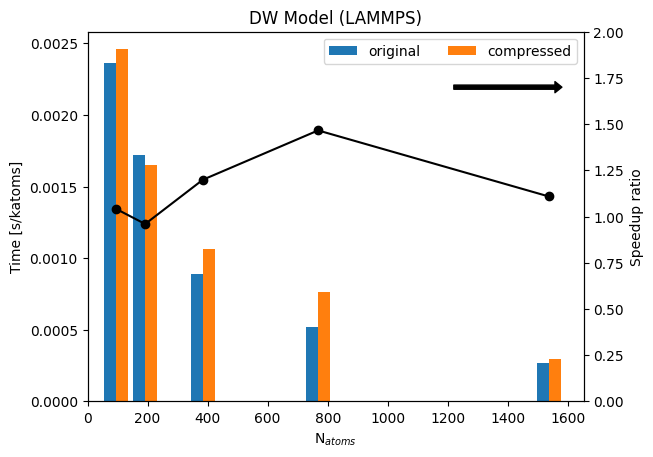

In [53]:
fig, ax = plt.subplots()

x = n_atoms
width = 40
multiplier = 0

ax.bar(
    x - width / 2,
    ts_ave / n_atoms * 1e3,
    width,
    # yerr=data_std / n_atoms * 1e3,
    label="original",
)
ax.bar(
    x + width / 2,
    ts_ave_compressed / n_atoms * 1e3,
    width,
    # yerr=data_compressed_std / n_atoms * 1e3,
    label="compressed",
)

ax.set_xlabel(r"N$_{atoms}$")
ax.set_ylabel(r"Time [s/katoms]")
ax.set_xlim(left=0)
ax.legend(ncols=2)

ax_r = ax.twinx()

ratio = np.array(ts_ave_compressed)/np.array(ts_ave)

ax_r.plot(n_atoms, ratio, color='black', marker='o')
ax_r.set_ylim(0, 2)
ax_r.annotate(
    "",
    xy=(1600, 1.7),
    xytext=(1200, 1.7),
    arrowprops=dict(facecolor="black", shrink=0.05, width=3, headwidth=8, headlength=5),
)
ax_r.set_ylabel("Speedup ratio")

fig.savefig("plot/py_dw.png")
plt.title('DW Model (LAMMPS)')
plt.show()

# DW gradient (python)


In [54]:
fnames = glob.glob("./py_dm/dw.*")
fnames.sort()
ts_grad_dw_dm_ave = []
for fname in fnames:
    ts_dm = np.loadtxt(fname)
    ts_dm = ts_dm[1:]
    ts_grad_dw_dm = ts_dm[:, 0]-ts_dm[:, 1]
    ts_grad_dw_dm_ave.append(np.mean(ts_grad_dw_dm))

fnames = glob.glob("./py_dm/dw-compressed.*")
fnames.sort()
ts_grad_dw_dm_compress_ave = []
for fname in fnames:
    ts_dm = np.loadtxt(fname)
    ts_dm = ts_dm[1:]
    ts_grad_dw_dm = ts_dm[:, 0]-ts_dm[:, 1]
    ts_grad_dw_dm_compress_ave.append(np.mean(ts_grad_dw_dm))

In [55]:
np.array(ts_grad_dw_dm_ave) / n_atoms * 1e3

array([0.07318879, 0.07325749, 0.07078601, 0.06848415, 0.06832708])

In [56]:
np.array(ts_grad_dw_dm_compress_ave) / n_atoms * 1e3

array([0.07174422, 0.07272342, 0.07238054, 0.07095139, 0.06610408])

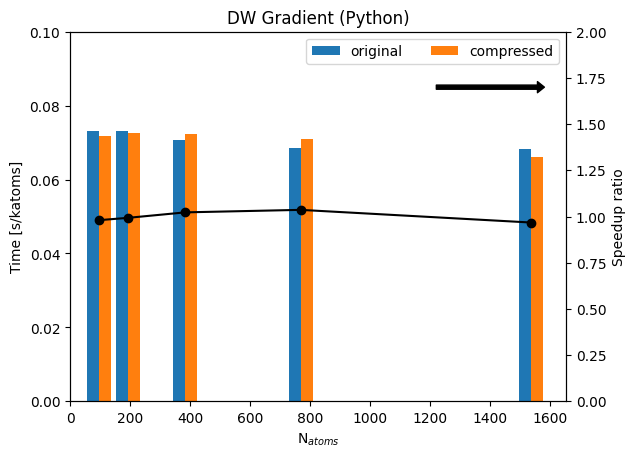

In [57]:
fig, ax = plt.subplots()

x = n_atoms
width = 40
multiplier = 0

ax.bar(
    x - width / 2,
    ts_grad_dw_dm_ave / n_atoms * 1e3,
    width,
    # yerr=data_std / n_atoms * 1e3,
    label="original",
)
ax.bar(
    x + width / 2,
    ts_grad_dw_dm_compress_ave / n_atoms * 1e3,
    width,
    # yerr=data_compressed_std / n_atoms * 1e3,
    label="compressed",
)

ax.set_xlabel(r"N$_{atoms}$")
ax.set_ylabel(r"Time [s/katoms]")
ax.set_xlim(left=0)
ax.set_ylim(top=0.1)
ax.legend(ncols=2)

ax_r = ax.twinx()

ratio = np.array(ts_grad_dw_dm_compress_ave)/np.array(ts_grad_dw_dm_ave)

ax_r.plot(n_atoms, ratio, color='black', marker='o')
ax_r.set_ylim(0, 2)
ax_r.annotate(
    "",
    xy=(1600, 1.7),
    xytext=(1200, 1.7),
    arrowprops=dict(facecolor="black", shrink=0.05, width=3, headwidth=8, headlength=5),
)
ax_r.set_ylabel("Speedup ratio")

fig.savefig("plot/py_dw.png")
plt.title('DW Gradient (Python)')
plt.show()